### Generate input data

<IPython.core.display.Javascript object>


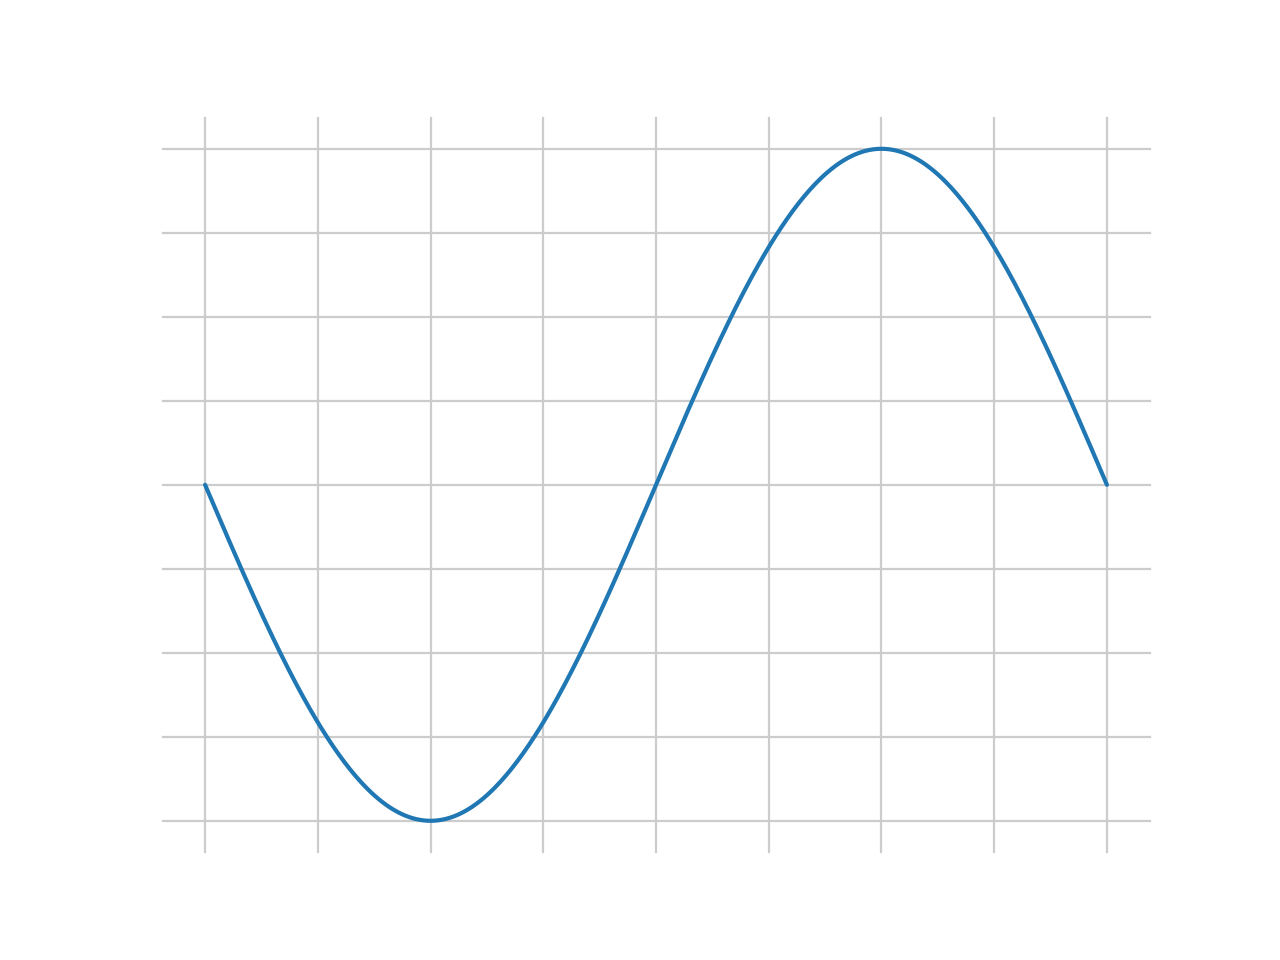

In [2]:
%matplotlib notebook
import math
import numpy as np
import matplotlib.pyplot as plt
# import plotly.plotly as ply
# import plotly.tools as tls
from IPython.display import clear_output
from tqdm import tqdm

# --- set problem input parameters here ---
Dmin           = -4.
Dmax           = 4.
nPoints        = 480
scale          = 1
sincFunc       = True
# ------------------------------------------

if sincFunc:
    x = np.linspace(Dmin, Dmax, nPoints)
#     y = scale * np.sinc(x+1)
    y = scale * np.sin(math.pi * x/4)
else:
    y = np.fromfile("s3d.raw", dtype=np.float64) #
    nPoints = y.shape[0]
    x = np.linspace(Dmin, Dmax, nPoints)

# plt.style.use(['dark_background'])
plt.style.use(['seaborn-whitegrid'])
# plt.style.use(['classic'])
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

mpl_fig = plt.figure()
plt.plot(x, y)

# ply.plot_mpl(mpl_fig)
# plotly_fig = tls.mpl_to_plotly(mpl_fig)
# plotly_fig['layout']['showlegend'] = True

# pltfigurl = ply.plot(mpl_fig)


In [3]:
# Initialize run context data
nSubDomains        = 1
degree             = 3
useAdditiveSchwartz = True
nControlPoints     = (2*degree + 1) #minimum number of control points

solverscheme = 'SLSQP' # [SLSQP, COBYLA]
nmaxiter = 10
maxErr = 1e-8

### LSQ B-spline approximation (scipy.interpolate.LSQUnivariateSpline)

<IPython.core.display.Javascript object>


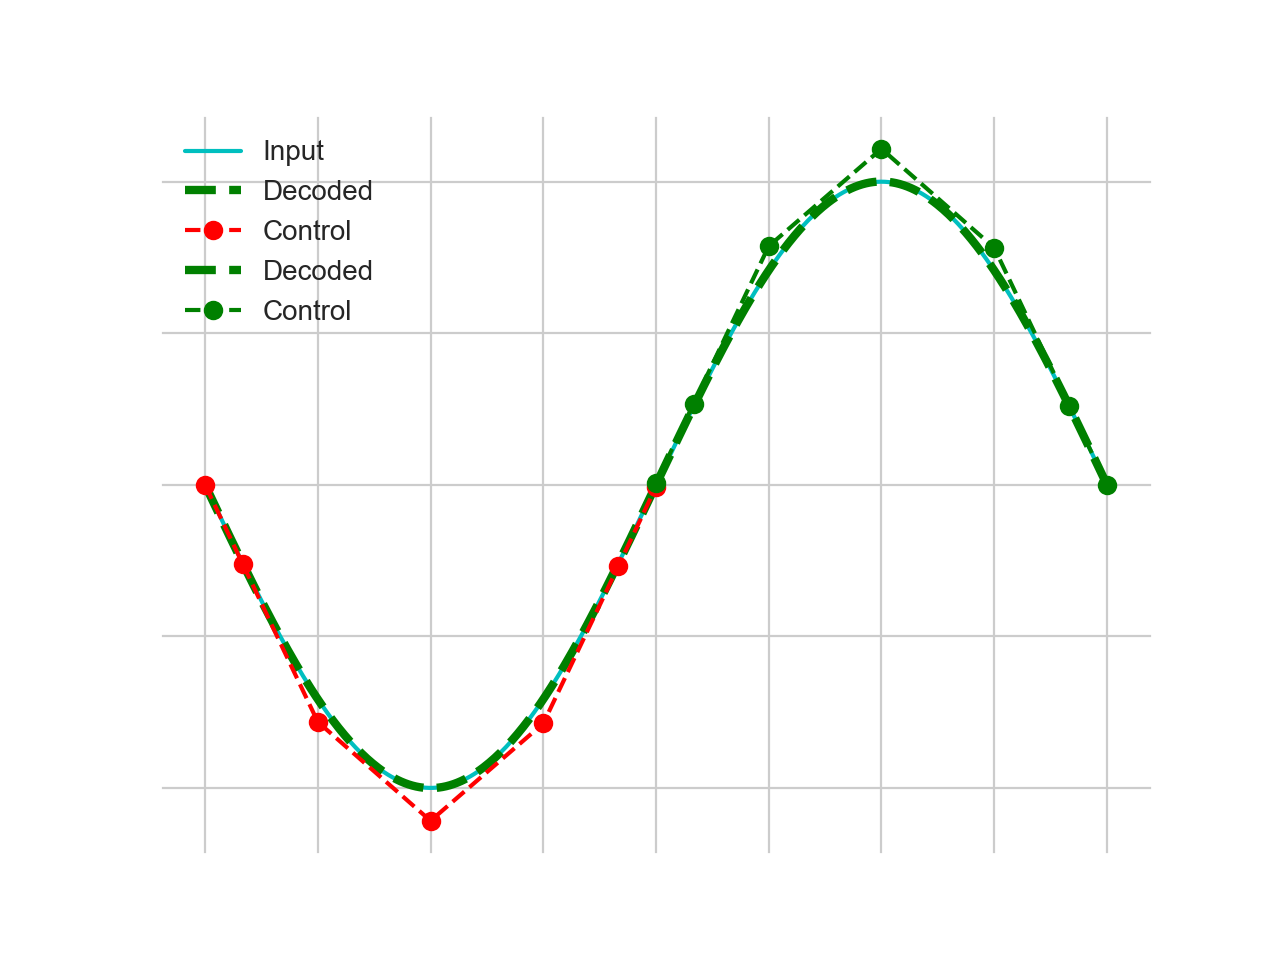

Nsubdomains:  2
U:  [0.         0.00209205 0.0041841  0.00627615 0.0083682  0.01046025
 0.0125523  0.01464435 0.0167364  0.01882845 0.0209205  0.02301255
 0.0251046  0.02719665 0.0292887  0.03138075 0.0334728  0.03556485
 0.0376569  0.03974895 0.041841   0.04393305 0.0460251  0.04811715
 0.05020921 0.05230126 0.05439331 0.05648536 0.05857741 0.06066946
 0.06276151 0.06485356 0.06694561 0.06903766 0.07112971 0.07322176
 0.07531381 0.07740586 0.07949791 0.08158996 0.08368201 0.08577406
 0.08786611 0.08995816 0.09205021 0.09414226 0.09623431 0.09832636
 0.10041841 0.10251046 0.10460251 0.10669456 0.10878661 0.11087866
 0.11297071 0.11506276 0.11715481 0.11924686 0.12133891 0.12343096
 0.12552301 0.12761506 0.12970711 0.13179916 0.13389121 0.13598326
 0.13807531 0.14016736 0.14225941 0.14435146 0.14644351 0.14853556
 0.15062762 0.15271967 0.15481172 0.15690377 0.15899582 0.16108787
 0.16317992 0.16527197 0.16736402 0.16945607 0.17154812 0.17364017
 0.17573222 0.17782427 0.17991632 0.182008

In [4]:
from scipy.interpolate import LSQUnivariateSpline, UnivariateSpline
from makruth_solver import getControlPoints

nControlPointSpans = nControlPoints - 1
nInternalKnotSpans = nControlPointSpans - degree + 1

plt.figure()
plt.plot(x, y, 'c-', ms=5, label='Input')

nSubDomains = 2
print('Nsubdomains: ', nSubDomains)
for iSubDom in range(1,nSubDomains+1):

    domStart = (iSubDom-1) * 1.0 / nSubDomains
    domEnd   = iSubDom * 1.0 / nSubDomains
    
    inc = (domEnd - domStart) / nInternalKnotSpans
    t   = np.linspace(domStart + inc, domEnd - inc, nInternalKnotSpans - 1)
    U   = np.linspace(domStart, domEnd, nPoints/nSubDomains)
    print('U: ', U)
    
#     dSpan = range( (iSubDom-1) * len(y) / nSubDomains, iSubDom * len(y) / nSubDomains )

    print('Range1: ', iSubDom, nSubDomains, len(y) )
    print('Range2: ', iSubDom, len(y), (iSubDom-1) * len(y) , iSubDom * len(y) )
    pSpan = int(len(y) / nSubDomains)
    dSpan = range( (iSubDom-1) * pSpan, iSubDom * pSpan )

    print ("iSubdomain: ", iSubDom, " Total: ", nPoints, " NSubdomain: ", nSubDomains)
    Dmini = Dmin + (Dmax - Dmin)*domStart
    Dmaxi = Dmin + (Dmax - Dmin)*domEnd
    print ("Subdomain span: ", Dmini, Dmaxi)

    spl = LSQUnivariateSpline(U, y[dSpan], t, k=degree)
    plt.plot(x[dSpan], spl(U), 'g--', lw=3, label='Decoded')

    # get the control points (not sure if these are right)
    knots    = spl.get_knots()
    knots    = np.concatenate(([knots[0]] * degree, knots, [knots[-1]] * degree))
    print('Knots: ', knots)

    knotsAlt  = np.concatenate(([domStart] * (degree+1), t, [domEnd] * (degree+1)))

    print('Knots from custom formula: ', knotsAlt)

    P        = spl.get_coeffs()
    coeffs_x = getControlPoints(knots, degree) * (Dmax - Dmin) + Dmin
    plt.plot(coeffs_x, P, marker='o', linestyle='--', color=['r','g','b','y','c'][iSubDom-1], label='Control')

    print ("Normalized knots:", 2 * (knots) / (Dmaxi - Dmini))
    print ("Subdomain: ", iSubDom, " -- Sum of squared residuals of the spline approximation", spl.get_residual())

plt.legend()
plt.show()

### Solve for control points and weights using Ma & Kruth (1995)

nInternalKnotSpans:  4


<IPython.core.display.Javascript object>


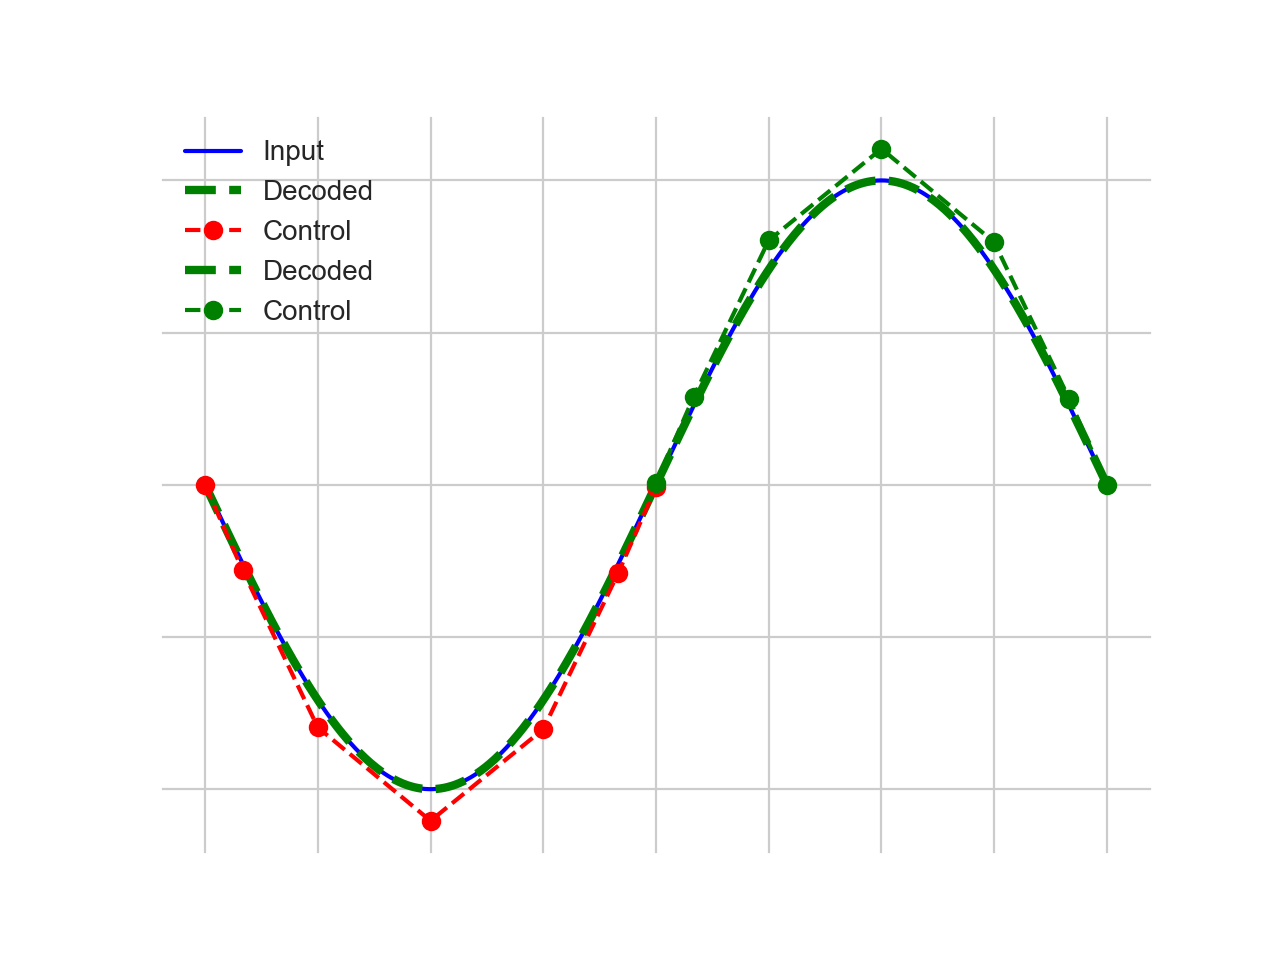

iSubdomain:  1  Total:  480  NSubdomain:  2
Subdomain span:  -4.0 0.0
Ma&Kruth Weights: [0.4136389  0.38449189 0.34852133 0.33610924 0.34997784 0.38728547
 0.41732217]
Subdomain:  1  -- L2 error:  4.844726073162099e-06 , Linf error:  1.7162739393598183e-05
-----------

iSubdomain:  2  Total:  480  NSubdomain:  2
Subdomain span:  0.0 4.0
Ma&Kruth Weights: [0.41732198 0.38728533 0.34997776 0.33610924 0.3485214  0.38449203
 0.41363908]
Subdomain:  2  -- L2 error:  4.844726148464581e-06 , Linf error:  1.716271908766427e-05
-----------

Ma-Kruth subdomain solution:  [[ 1.69914514e-05  6.54143890e-03]
 [-2.81219890e-01  2.88231795e-01]
 [-7.97098589e-01  8.02942776e-01]
 [-1.10389490e+00  1.10389490e+00]
 [-8.02942819e-01  7.97098632e-01]
 [-2.88231818e-01  2.81219914e-01]
 [-6.54143888e-03 -1.69914717e-05]]


In [5]:
from makruth_solver import compute_mak95_fit

POptDomain = compute_mak95_fit(nSubDomains, degree, nControlPoints, x, y)
print ('Ma-Kruth subdomain solution: ', POptDomain)

### Use the solver with constraints now.

Using the minimization method =  SLSQP


<IPython.core.display.Javascript object>


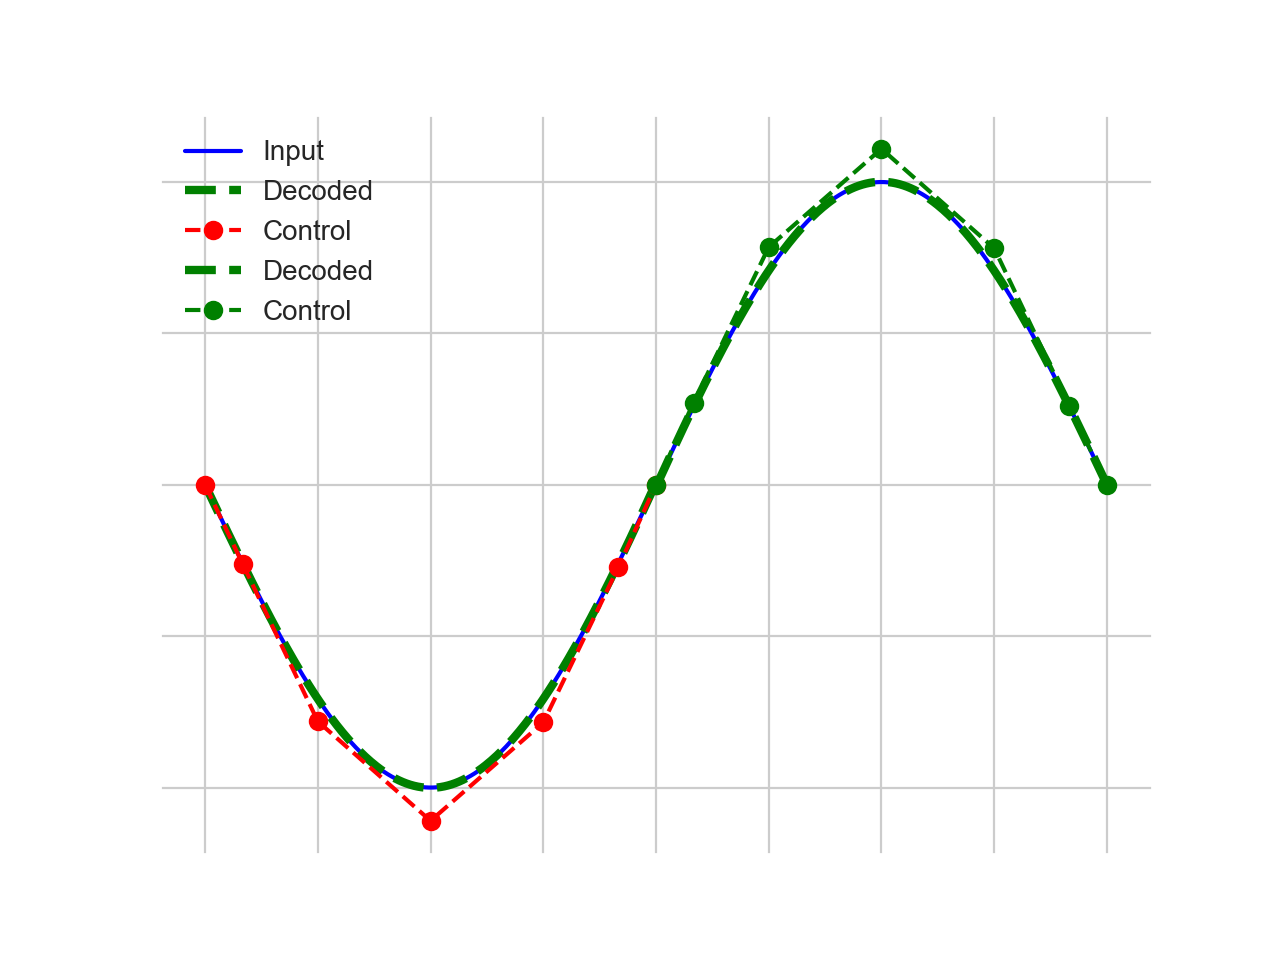

Subdomain:  1  -- L2 error:  0.001128971277894479 , Linf error:  0.0065586368010267975
Subdomain:  2  -- L2 error:  0.0011289827037637603 , Linf error:  0.006558636780720864
Constrained solution from  SLSQP :  (array([[ 4.09984484e-06,  1.01527380e-11],
       [-2.61503281e-01,  2.71688452e-01],
       [-7.81337120e-01,  7.85017813e-01],
       [-1.10978351e+00,  1.10977954e+00],
       [-7.85004835e-01,  7.81330553e-01],
       [-2.71682482e-01,  2.61499987e-01],
       [ 1.01527380e-11, -6.63787856e-06]]), array([0.625, 0.75 , 0.875]), array([1., 1., 1., 1., 1., 1., 1.]))


In [6]:
from makruth_solver import compute_mak95_fit_with_constraints

print ('Using the minimization method = ', solverscheme)
newconstraints = compute_mak95_fit_with_constraints(nSubDomains, degree, nControlPoints, x, y, POptDomain, useAdditiveSchwartz, True, False, solver=solverscheme)
print ('Constrained solution from ', solverscheme, ': ', newconstraints)

### Iteratively compute the Constrained Least-Squares solution to converge subdomain MFA approximations


Essentially we are performing recursive Fixed-Point iterations to converge the subdomain problem such that the interface conditions are matched exactly. The problem is iterative since the change in the interface value also affects the interior domain values slightly, and such a process requires multiple passes to converge depending on the gradient change from the interface. The convergence rate should in general not depend on the number of subdomains, i.e., as we increase n(subdomains), the rate stays linear and not degrade.

Future work: There are ways to accelerate this convergence with Aitken or Wynn-Epsilon schemes since FPI is only linearly convergent and hence computationally expensive.

In [9]:

# Use the previous MAK solver solution as initial guess; Could do something clever later
# interface_constraints=POptDomain.copy()
interface_constraints=newconstraints
print ("Initial condition data: ", interface_constraints)

errors = np.zeros([nmaxiter,2]) # Store L2, Linf errors as function of iteration

for iterIdx in range(nmaxiter):

    # Call our MFA functional fitting routine for all the subdomains
    newconstraints = compute_mak95_fit_with_constraints(nSubDomains, degree, nControlPoints, x, y,
                                                        interface_constraints, useAdditiveSchwartz, False, False, solver=solverscheme)

    # Let's compute the delta in the iterate
    iteratedelta = (np.array(newconstraints)-np.array(interface_constraints))
    # Essentially performing (unweighted) Richardson's iteration for converging
    # the subdomain problem
    #
    #    $y_{n+1} = y_n - 0.5 * \delta y_n = 0.5 * (y_n + y_{n+1})$
    # 
    # Future work: There are ways to accelerate this convergence with 
    # Aitken or Wynn-Epsilon schemes since Richardson is linearly 
    # convergent and produces approximations to the fixed point solution
    interface_constraints = newconstraints[:,:].copy() # - 0.5 * iteratedelta

    # Compute the error and convergence
    errors[iterIdx, 0] = math.sqrt(np.sum(iteratedelta**2))
    errors[iterIdx, 1] = np.max(iteratedelta)
    print ("\nIteration: ", iterIdx, " -- L2 error: ", errors[iterIdx, 0], ", Linf error: ", errors[iterIdx, 1])
    print ("\tUpdated data: ", interface_constraints)
    print ("\tIterate delta: ", iteratedelta)
    print ("------------------------\n")

    # Check for convergence
    if errors[iterIdx, 0] < maxErr:
        break

# Finally, let's show the plot with the newly computed solution
newconstraints = compute_mak95_fit_with_constraints(nSubDomains, degree, nControlPoints, x, y,
                                                    interface_constraints, useAdditiveSchwartz, True, True, solver=solverscheme)

if iterIdx > 1:
    plt.figure()
    plt.plot(range(iterIdx+1), np.log10(errors[:,0]), 'b--', ms=5, label='L_2 error')
    plt.plot(range(iterIdx+1), np.log10(errors[:,1]), 'r--', lw=3, label='Linf error')
    plt.legend()
    plt.show()


Initial condition data:  (array([[ 4.09984484e-06,  1.01527380e-11],
       [-2.61503281e-01,  2.71688452e-01],
       [-7.81337120e-01,  7.85017813e-01],
       [-1.10978351e+00,  1.10977954e+00],
       [-7.85004835e-01,  7.81330553e-01],
       [-2.71682482e-01,  2.61499987e-01],
       [ 1.01527380e-11, -6.63787856e-06]]), array([0.625, 0.75 , 0.875]), array([1., 1., 1., 1., 1., 1., 1.]))


TypeError: tuple indices must be integers or slices, not tuple

nInternalKnotSpans:  7


<IPython.core.display.Javascript object>


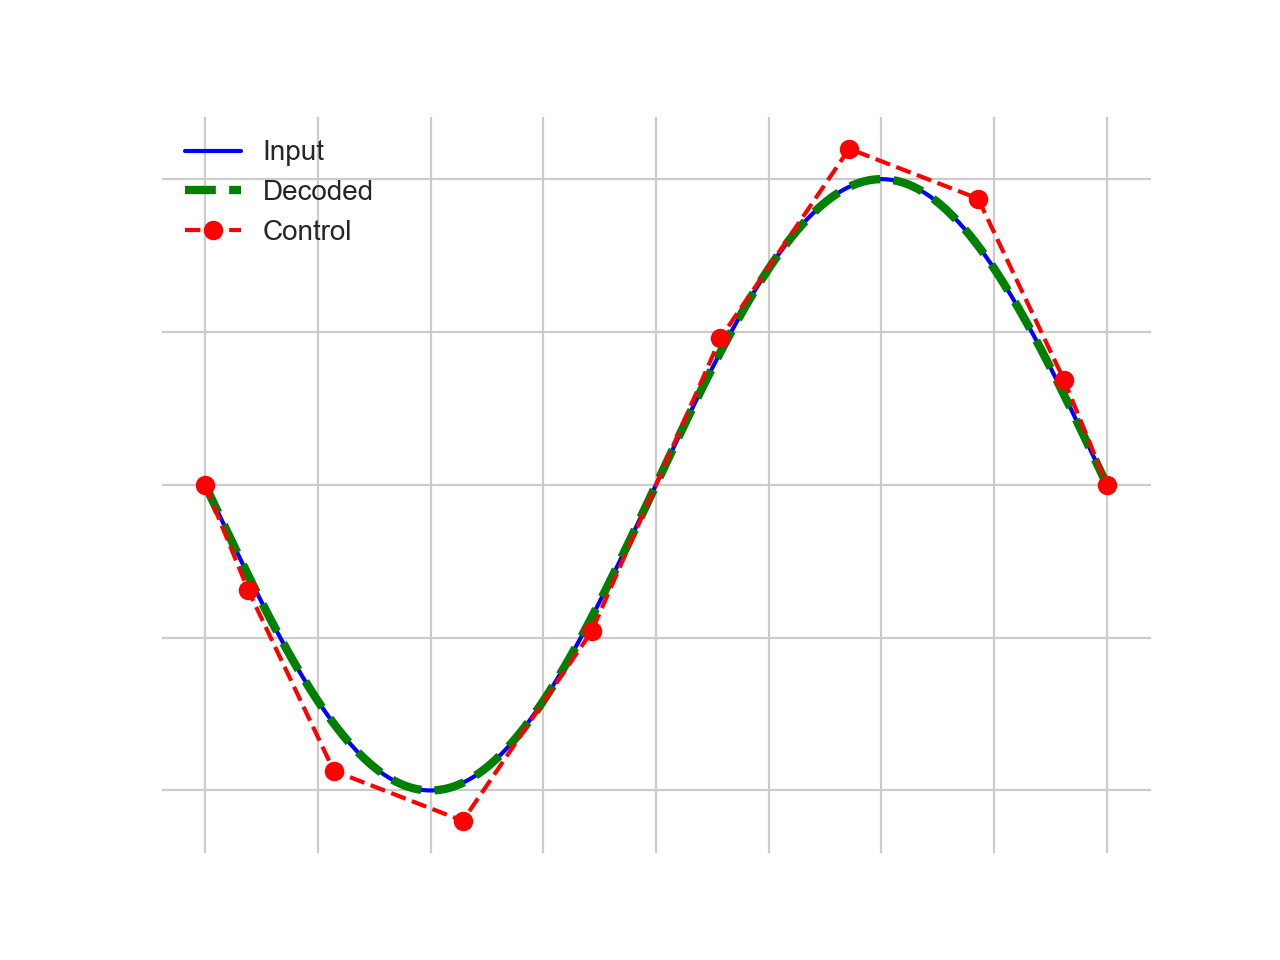

iSubdomain:  1  Total:  480  NSubdomain:  1
Subdomain span:  -4.0 4.0
Ma&Kruth Weights: [0.41345238 0.36077879 0.29334829 0.24821472 0.22634492 0.22634492
 0.24821472 0.29334829 0.36077879 0.41345238]
Subdomain:  1  -- L2 error:  0.0002359512896193072 , Linf error:  2.367936783670405e-05
-----------



<IPython.core.display.Javascript object>


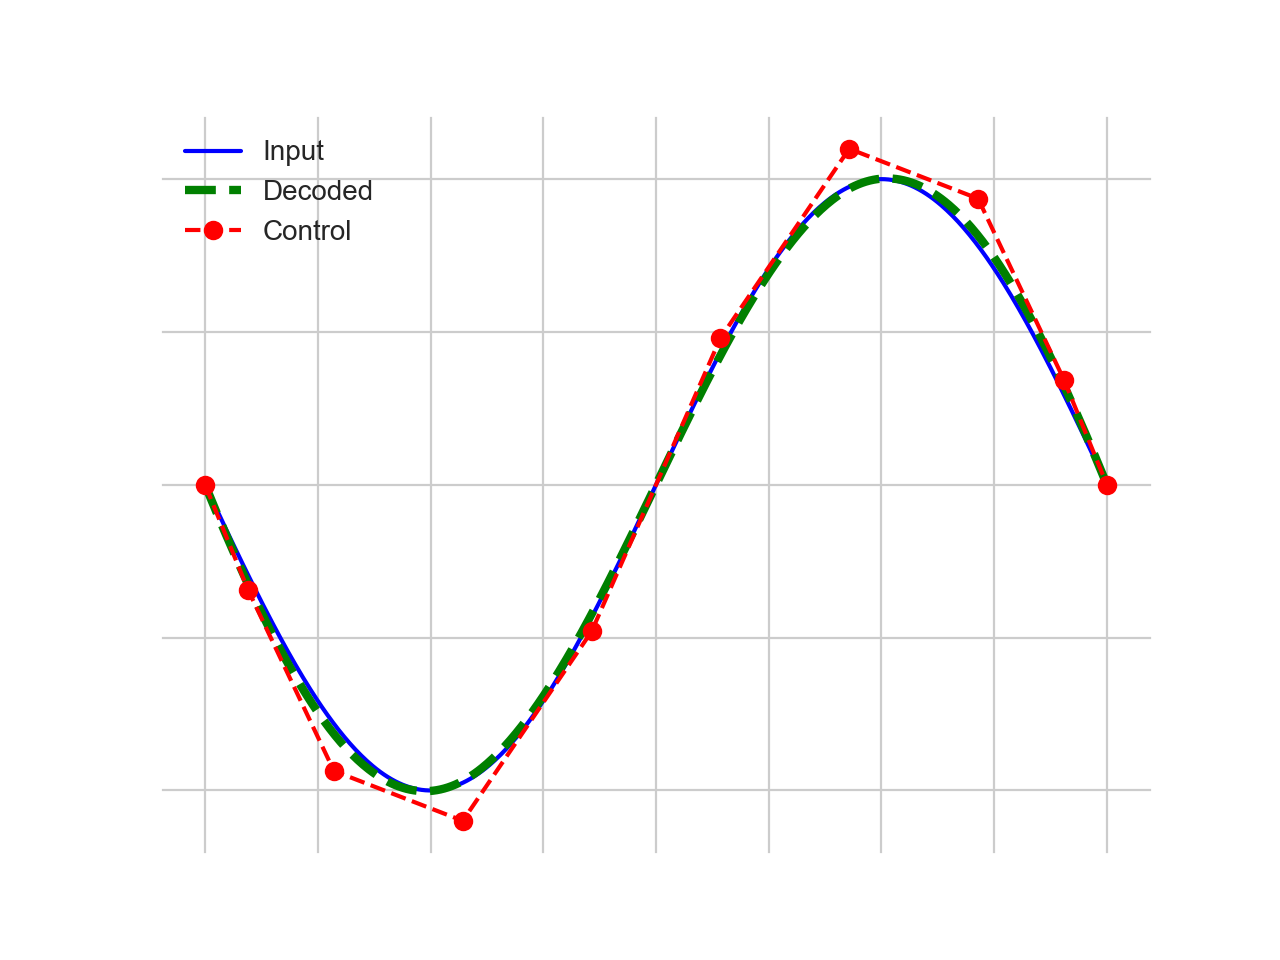

nInternalKnotSpans:  12


<IPython.core.display.Javascript object>


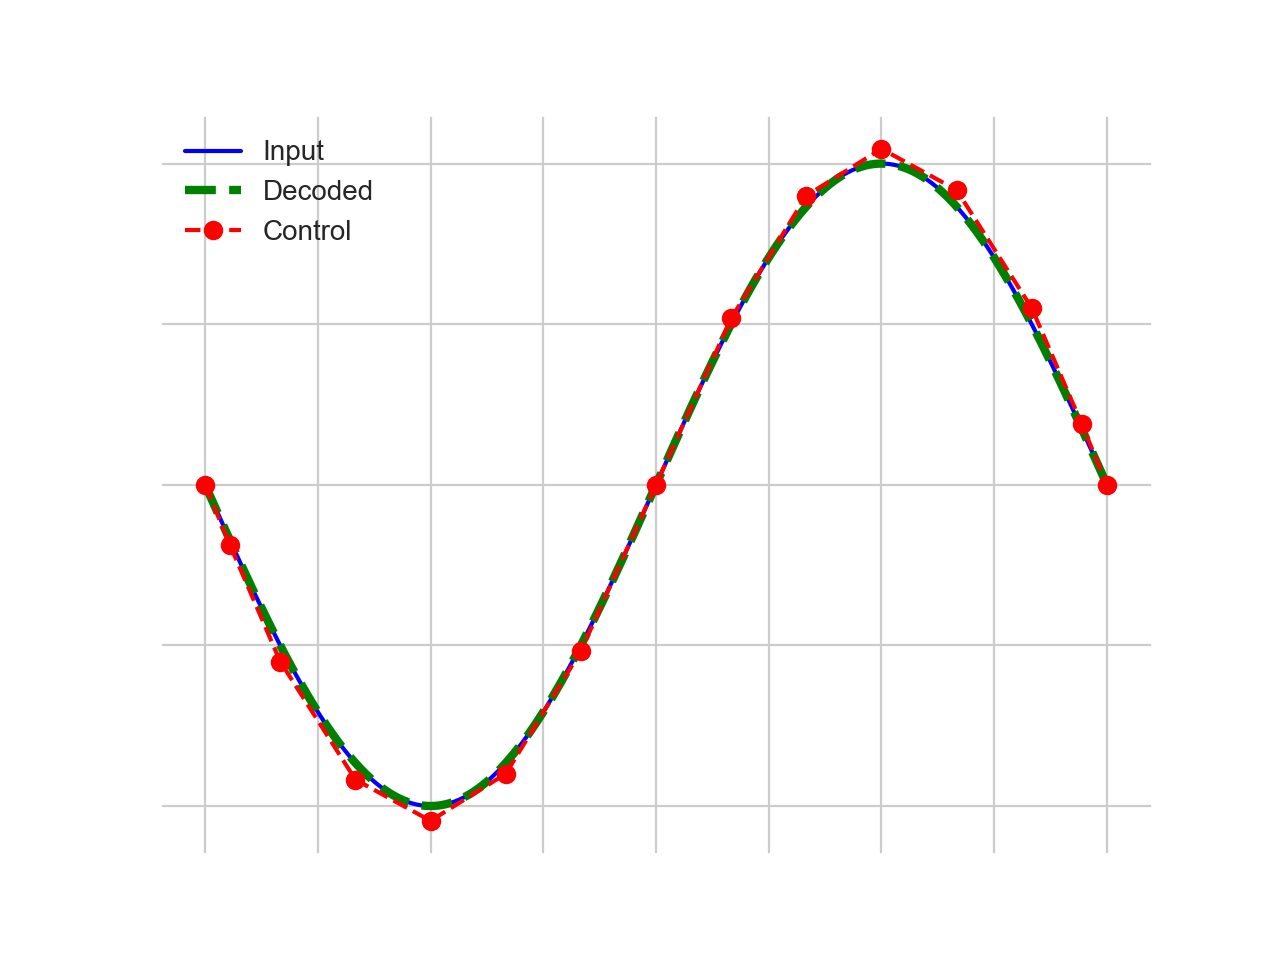

iSubdomain:  1  Total:  480  NSubdomain:  1
Subdomain span:  -4.0 4.0
Ma&Kruth Weights: [0.34756141 0.3215648  0.2809909  0.24134961 0.21583036 0.19822978
 0.1884963  0.18538087 0.18849629 0.19822977 0.21583033 0.24134958
 0.28099087 0.32156476 0.34756136]
Subdomain:  1  -- L2 error:  3.38623534997404e-05 , Linf error:  2.8006556086050492e-06
-----------



<IPython.core.display.Javascript object>


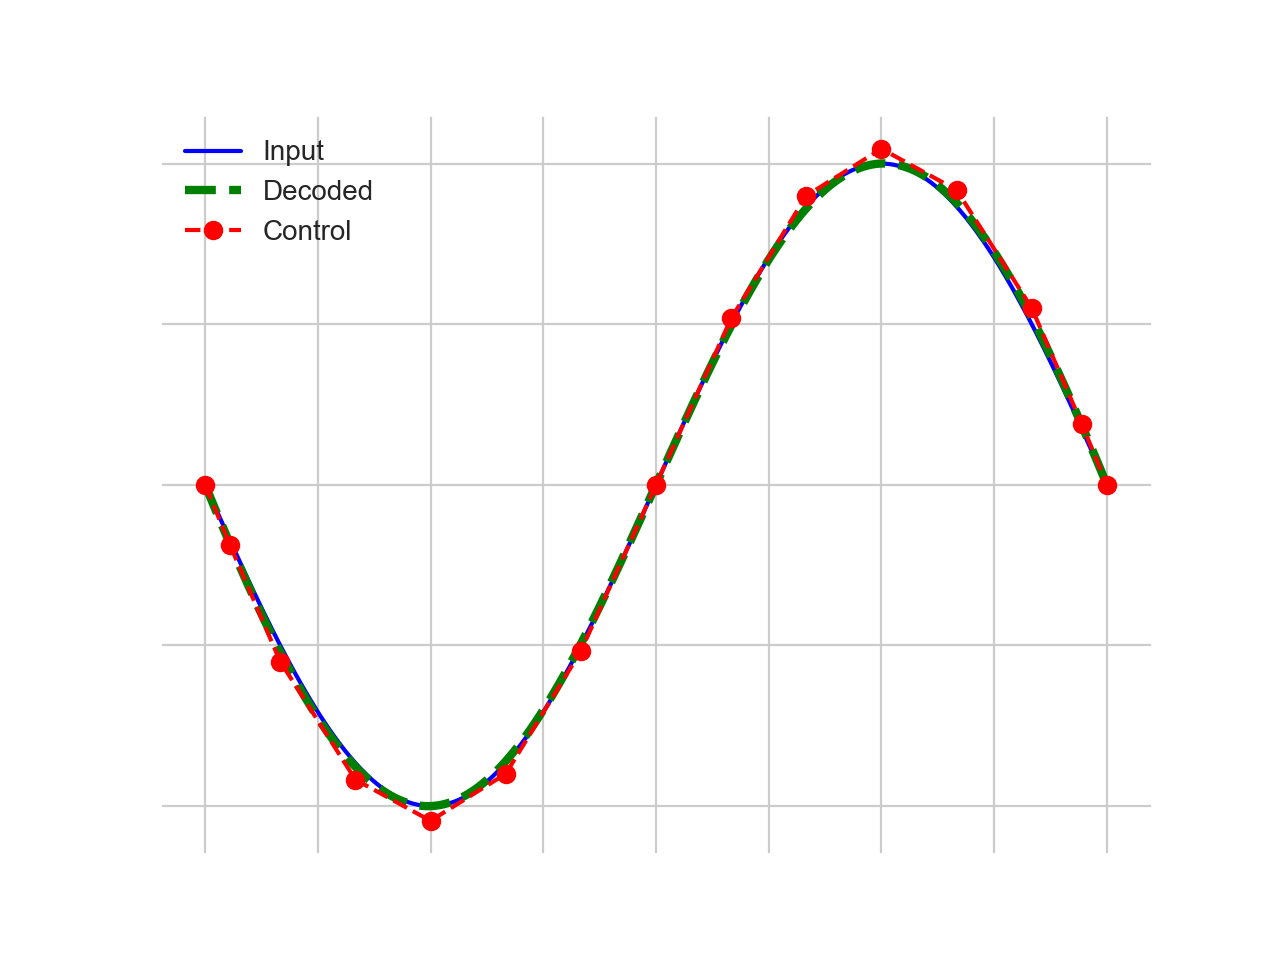

In [11]:
from makruth_solver import compute_mak95_fit_with_constraints
# Finally, let's show the plot with the newly computed solution
nControlPoints1 = 10
nControlPoints2 = 15
nSD = 1
POptDomain1 = compute_mak95_fit(nSD, degree, nControlPoints1, x, y)
newconstraints1, knots1, W1 = compute_mak95_fit_with_constraints(nSD, degree, nControlPoints1, x, y,
                                                    POptDomain1, False, True, True, solver=solverscheme)
POptDomain2 = compute_mak95_fit(nSD, degree, nControlPoints2, x, y)
newconstraints2, knots2, W2 = compute_mak95_fit_with_constraints(nSD, degree, nControlPoints2, x, y,
                                                    POptDomain2, False, True, True, solver=solverscheme)

coeffs_x1 = getControlPoints(Tu, degree)
coeffs_x2 = getControlPoints(Tu, degree)



###### Scratch space

In [ ]:
print len(x), len(y)
print coeffs_x
print len(errors)
print errors
print iterIdx